In [89]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn

# !pip install gradio
import gradio as gr

In [90]:
print(torch.cuda.is_available())
device = 'cuda'

True


In [91]:
transform = transforms.ToTensor()

training = datasets.MNIST('./data', train=True, download=True, transform=transform)
testing = datasets.MNIST('./data', train=False, download=True, transform=transform)

In [92]:
from torch.utils.data import random_split

train_set, dev_set = random_split(training, [50000, 10000])

In [93]:
training_loader = DataLoader(train_set, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=32)
testing_loader = DataLoader(testing, batch_size=32)

In [94]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, dropout=0.0, batch_norm=True):
        super().__init__()
        self.layers = [input_size] + hidden_layers + [output_size]
        self.network_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.relu = nn.ReLU()
        self.dropout_prob = dropout
        self.dropout = nn.Dropout(self.dropout_prob)

        for i in range(len(self.layers)-1):
            self.network_layers.append(nn.Linear(self.layers[i], self.layers[i+1]))
            if batch_norm == True:
                self.batch_norm_layers.append(nn.BatchNorm1d(self.layers[i+1]))

    def forward(self, x):
        for i in range(len(self.network_layers)-1): # all layers except output
            x = self.network_layers[i](x)
            if self.batch_norm:
                x = self.batch_norm_layers[i](x)
            x = self.relu(x)
            x = self.dropout(x)

        #output
        x = self.network_layers[-1](x)
        return x

In [95]:
net = NeuralNetwork(784, [256], 10, dropout=0.3, batch_norm=True).cuda()
print(net.layers)

[784, 256, 10]


In [96]:
def dataset_accuracy(model, loader):
    model.eval()

    with torch.no_grad():
        correct_predictions = 0
        for X, y in loader:

            X = X.reshape(-1, 784).cuda()
            y = y.cuda()

            output = model(X)
            correct_predictions += torch.sum(torch.max(output, 1)[1] == y).item()

        model.train()
        return correct_predictions / len(loader.dataset)

In [97]:
import torch.optim

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.06)


epochs = 20
for epoch in range(epochs):

    epoch_loss = 0
    correct_predictions = 0

    for X, y in training_loader:

        X = X.reshape(-1, 784).cuda()
        y = y.cuda()

        optimizer.zero_grad()
        output = net(X)
        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        correct_predictions += torch.sum(torch.max(output, dim=1)[1] == y).item()

    loss_score = epoch_loss/len(training_loader)
    training_accuracy = correct_predictions/len(training_loader.dataset)
    dev_accuracy = dataset_accuracy(net, dev_loader)

    print(f"epoch: {epoch+1}  loss = {loss_score}, training accuracy = {training_accuracy}, dev accuracy = {dev_accuracy}")

print('------------------')
print(f'Test set accuracy = {dataset_accuracy(net, testing_loader)}')

epoch: 1  loss = 0.2890424564044615, training accuracy = 0.91692, dev accuracy = 0.9599
epoch: 2  loss = 0.16554233085743067, training accuracy = 0.95176, dev accuracy = 0.9682
epoch: 3  loss = 0.13723195586961312, training accuracy = 0.95902, dev accuracy = 0.9703
epoch: 4  loss = 0.11719332644042588, training accuracy = 0.96506, dev accuracy = 0.973
epoch: 5  loss = 0.1070253730251651, training accuracy = 0.96746, dev accuracy = 0.9741
epoch: 6  loss = 0.1012510137947697, training accuracy = 0.96936, dev accuracy = 0.9748
epoch: 7  loss = 0.09661371271010973, training accuracy = 0.97054, dev accuracy = 0.9746
epoch: 8  loss = 0.08923686312789232, training accuracy = 0.97332, dev accuracy = 0.9768
epoch: 9  loss = 0.08402769899613063, training accuracy = 0.97516, dev accuracy = 0.9781
epoch: 10  loss = 0.08109976613824986, training accuracy = 0.9753, dev accuracy = 0.977
epoch: 11  loss = 0.08024608795557908, training accuracy = 0.97594, dev accuracy = 0.9764
epoch: 12  loss = 0.07614

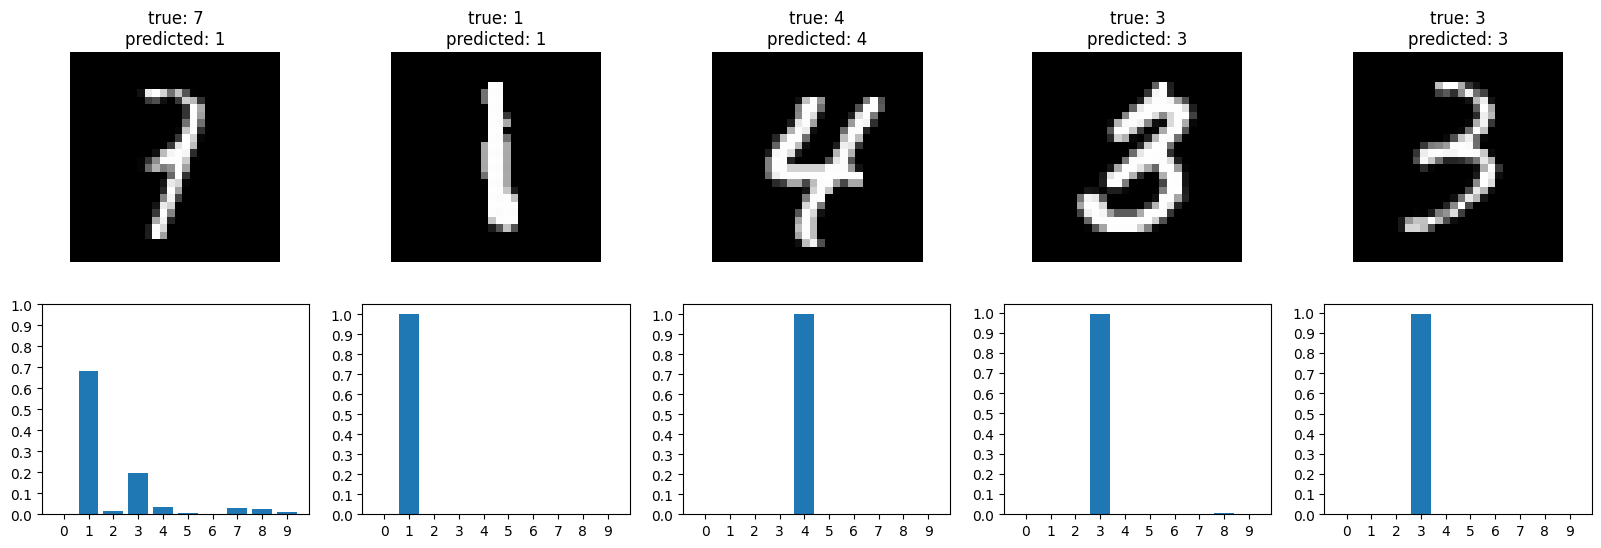

In [98]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_mnist(model, loader, num_images = 5):
    random_choices = np.random.randint(1, 10000, size=num_images)

    images_list = []
    labels_list = []
    predictions_list = []
    probability_distributions_list = []

    model.eval()
    with torch.no_grad():
        for choice in random_choices:
            X, y = loader.dataset[choice]
            X = X.reshape(-1, 784).to('cuda:0')

            logits = model(X)

            _, pred = torch.max(logits, 1)
            predictions_list.append(pred.item())

            probability_distributions_list.append(torch.softmax(logits, 1))

            images_list.append(X.cpu())
            labels_list.append(y)

    fig, axes = plt.subplots(2, num_images, figsize=(20, 6))
    for i in range(num_images):
        axes[0, i].imshow(images_list[i].reshape(28,28), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'true: {labels_list[i]}\npredicted: {predictions_list[i]}')
        axes[1, i].bar(x=np.arange(10), height=probability_distributions_list[i].cpu().numpy().squeeze())
        axes[1, i].set_xticks(np.arange(10))
        axes[1, i].set_yticks(np.linspace(0.0, 1, 11))

    model.train()
    plt.show()
visualize_mnist(net, testing_loader)

In [99]:
#save the model
# torch.save(net, 'trained_model.pth')

In [100]:
#load the model (from github)
# torch.load('trained_model.pth', weights_only=False)

In [101]:
import gradio as gr
from PIL import Image

def predict(img):
    # print(img.keys())

    if isinstance(img, dict):
        img = img["composite"]

    if img is None:
        return {str(i): 0.0 for i in range(10)}


    pil = Image.fromarray(img)
    pil = pil.resize((28, 28)).convert('L')
    image = np.array(pil, dtype=np.float32) / 255.0
    image = image.reshape(-1, 28*28)

    image = 1.0 - image


    with torch.no_grad():
        net.eval()

        output = net(torch.from_numpy(image).cuda())
        prediction = torch.softmax(output, 1).cpu().numpy()[0]

        net.train()


    return {str(i): float(prediction[i]) for i in range(10)}

In [102]:
demo = gr.Interface(fn=predict, inputs=gr.Sketchpad(), outputs=gr.Label(num_top_classes=10), live=True)
demo.launch(share=True, debug=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0aa2adc223b75da28d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
